<a href="https://colab.research.google.com/github/wangdaming155/bootstrap/blob/main/%E8%AE%A1%E7%AE%97%E6%9C%BA%E8%A7%86%E8%A7%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/d2l-zh')

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
%matplotlib inline
import torch
import torchvision

In [5]:
pwd

'/content/drive/MyDrive/d2l-zh'

In [6]:
mv img /content/drive/MyDrive/

mv: cannot stat 'img': No such file or directory


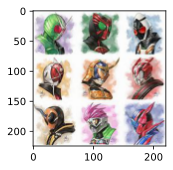

In [7]:
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img)

In [8]:
def apply(img, aug, num_rows=2, num_cols = 4, scale = 1.5):
  Y = [aug(img) for _ in range(num_rows*num_cols)]
  d2l.show_images(Y, num_rows, num_cols, scale=scale)

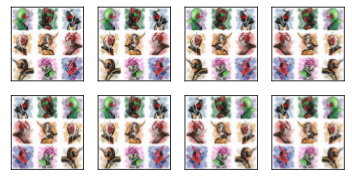

In [9]:
apply(img,torchvision.transforms.RandomHorizontalFlip())

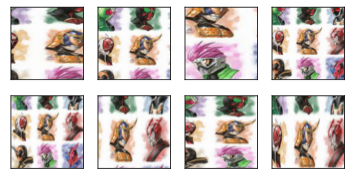

In [10]:
####随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5到2之间随机取值####
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200,200), scale=(0.1,1), ratio=(0.5,2)
)
apply(img, shape_aug)

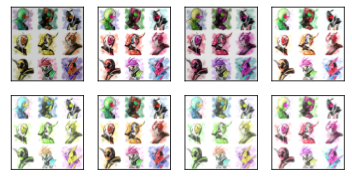

In [11]:
### change the brightness ,contrast, saturation, hue####
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.2, saturation=0, hue=0.4))

      

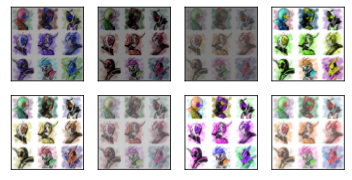

In [12]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img,color_aug)

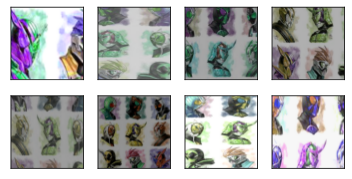

In [13]:
augs = torchvision.transforms.Compose([
  torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug
                                       
])
apply(img,augs)

Files already downloaded and verified


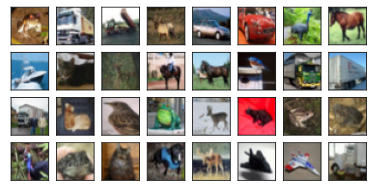

In [14]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [15]:
train_augs = torchvision.transforms.Compose([
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.ToTensor()    #数值转化
])
test_augs = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor()
])

In [23]:
from torchvision import transforms
def load_cifar10(is_train, augs, batch_size):
  dataset = torchvision.datasets.CIFAR10(root="../data",train=is_train,
                                         transform=augs,download=True)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train,
                        num_workers=d2l.get_dataloader_workers())
  return dataloader

In [17]:
!nvidia-smi

Fri Jul 29 12:49:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
  """用多Gpu进行小批量训练"""
  if isinstance(X,list):
    X = [x.to(device[0])for x in X]
  else:
    X = X.to(devices[0])
  y = y.to(devices[0])
  net.train()
  trainer.zero_grad()
  pred = net(X)
  l = loss(pred,y)
  l.sum().backward()
  trainer.step()
  train_loss_sum = l.sum()
  train_acc_sum = d2l.accuracy(pred, y)
  return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
  """用多GPU进行模型训练"""
  timer, num_batches = d2l.Timer(), len(train_iter)
  animator = d2l.Animator(xlabel = 'epoch', xlim=[1,num_epochs], ylim=[0,1], legend=['train loss', 'train acc', 'test acc'])
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    #四个维度，储存训练损失，训练准确度，实例数，特点数
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch_ch13(
          net, features, labels, loss, trainer, devices
      )
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
      if (i+1)%(num_batches // 5) == 0 or i == num_batches-1:
        animator.add(epoch+(i+1)/num_batches,
                     (metric[0]/metric[2],metric[1]/metric[3],
                      None))   #loss和acc针对train而言
    test_acc = d2l.evaluate_accuracy_gpu(net, test_iter) #针对test的acc
    animator.add(epoch+1, (None, None, test_acc))
  print(f'loss {metric[0]/metric[2]:.3f}, train acc'
     f'{metric[1]/metric[3]:.3f}, test acc {test_acc:.3f}'
     )
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')
        


In [21]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.151, train acc0.947, test acc 0.837
1160.7 examples/sec on [device(type='cuda', index=0)]


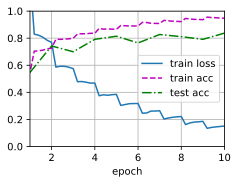

In [28]:
train_with_data_aug(train_augs, test_augs, net)

* 微调

In [31]:

d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [32]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

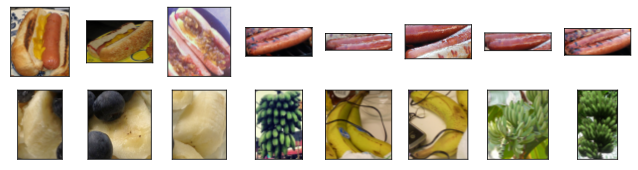

In [33]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [34]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
)
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize
])

In [35]:
pretrained_net = torchvision.models.resnet18(pretrained = True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [36]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [37]:
finetune_net = torchvision.models.resnet18(pretrained = True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features,2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[-0.0167,  0.0577,  0.0421,  ...,  0.0125,  0.0782,  0.0486],
        [-0.0001,  0.0183, -0.0917,  ...,  0.0060,  0.0502, -0.0410]],
       requires_grad=True)

In [38]:
def train_fine_tuning(net, learning_rate, batch_size= 128, num_epochs = 5, param_group=True):
  train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform = train_augs),
        batch_size=batch_size, shuffle=True)
  test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
  devices = d2l.try_all_gpus()
  loss = nn.CrossEntropyLoss(reduction="none")
  if param_group:
    param_1x = [param for name, param in net.named_parameters()
        if name not in ["fc.weight","fc.bias"]]
    trainer = torch.optim.SGD([{'params':param_1x},
                  {'params':net.fc.parameters(),
                   'lr': learning_rate* 10}],
                   lr=learning_rate,weight_decay=0.001)
  else:
    trainer = torch,optim.SGD(net.parameters(),lr=learning_rate,weight_decay=0.001)
  d2l.train_ch13(net,train_iter,test_iter,loss, trainer, num_epochs, devices)

loss 0.188, train acc 0.932, test acc 0.934
357.0 examples/sec on [device(type='cuda', index=0)]


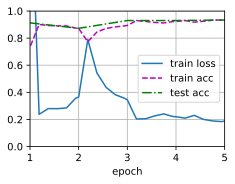

In [39]:
train_fine_tuning(finetune_net,5e-5)

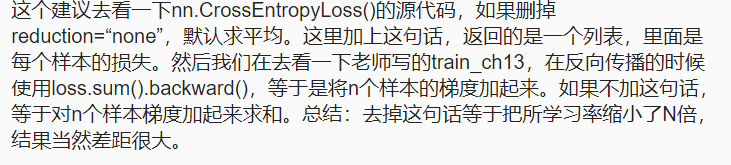

# 目标检测

In [40]:

def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

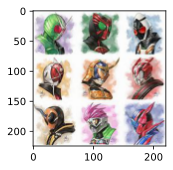

In [41]:
d2l.set_figsize()
img = d2l.plt.imread('../img/cat1.jpg')
d2l.plt.imshow(img);

In [42]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [43]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [44]:

def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

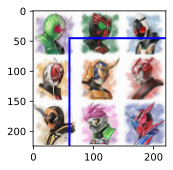

In [45]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

# 锚框

In [46]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # 精简输出精度